In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

# Preprocess Transaction Dataset using Dask cuDF on Multiple GPUs

In this notebook we walk-though how to accelerate data preprocessing for turning Tabular Transaction data into DGL Heterograph consists of cards and merchants as nodes and transactions as edges using NVIDIA GPUs and cuDF library.

## About Transaction Dataset

In the Tabformer Credit Card Fraud Transaction Dataset we have data for:

*  **~24 million transactions** 
* for 2000 unique users spanning years 1990-2020 
* with each user having multiple credit cards spanning 1-9 unique cards, avg is 3 cards per user
* There are total 6,139 unique credit cards 
* 100,343 unique merchants 
* 109 unique MCCs
* 27,321 unique zip codes
* 13,429 unique cities (includes US cities and foreign cities)
* 223 unique values for Merchant State (171 forerign countries + 52 US States and Territories)

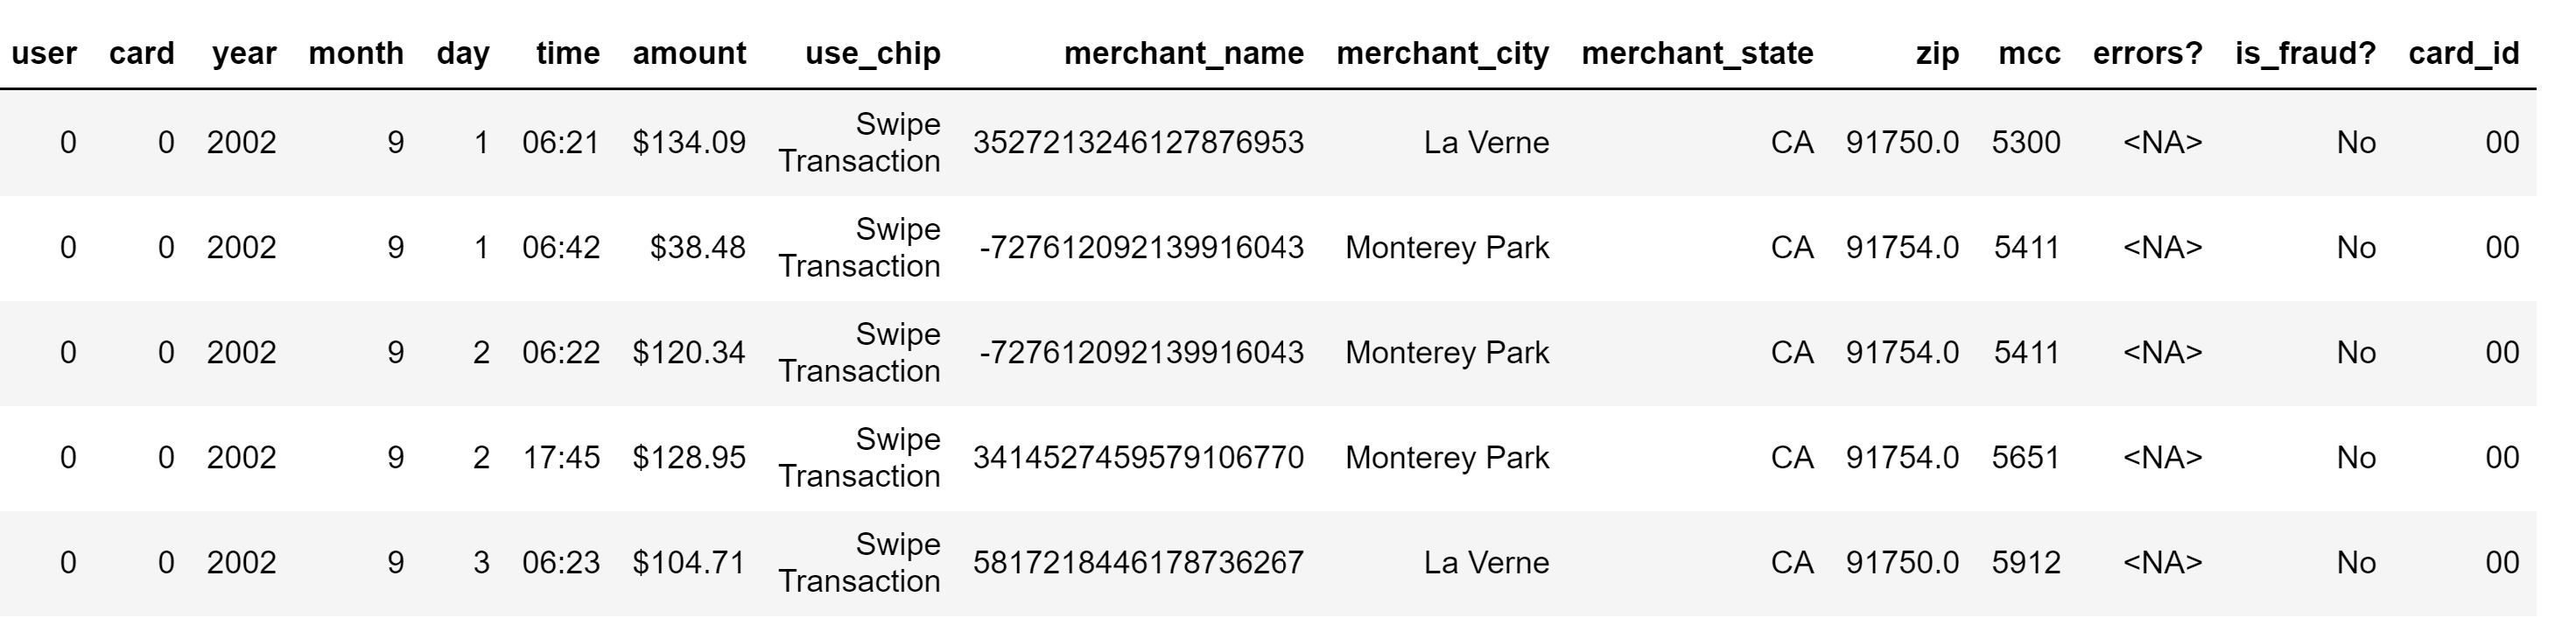

In [1]:
import os
import subprocess
import shutil
import cudf
import dask_cudf
import pandas as pd
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import torch
import dgl
from utils import device_mem_size, get_rmm_size

Using backend: pytorch


In [2]:
BASE_DIR = "./basedir"

In [3]:
# Ensure BASE_DIR exists
if not os.path.isdir(BASE_DIR):
    os.mkdir(BASE_DIR)

## Download Data

Please download the dataset from this [link](https://github.com/IBM/TabFormer/tree/main/data/credit_card), extract it and place in the folder called `data` inside the `BASE_DIR`

In [4]:
# CHANGE ME
DATA_DIR = 'data'

In [5]:
data_path = os.path.join(BASE_DIR, DATA_DIR)

In [6]:
# Define our processed data path
processed_path = os.path.join(BASE_DIR, "processed_data_mgpu")
dask_space = os.path.join(BASE_DIR, "dask_space")

In [7]:
# Make sure we have a clean worker space for Dask
if os.path.isdir(dask_space):
    shutil.rmtree(dask_space)
os.mkdir(dask_space)

## Setup a Single-Machine Multi-GPU Dask Cluster

If you are running this on a DGX-1 or DGX-2 or DGX A100 then that's a single node Multi-GPU cluster and we can set up a Multi-GPU Dask cluster on it as follows. 

### GPU-to-CPU (Device-to-Host) Memory Spilling

One of the advantages of using Dask-CUDA to deploy a distributed cluster is that the workers will move data between device (GPU) memory and host (CPU) memory, and between host memory and disk, to avoid out-of-memory (OOM) errors. **By default, Dask-CUDA enables spilling from GPU to host memory when a GPU reaches a memory utilization of 80%.** Since  spilling can reduce the overall performance of a workflow, you should set `device_memory_limit setting` to a lower value like 0.7 or 0.5 when it proves absolutely necessary (i.e. heavy spilling is deemed inevitable for a given workflow).

### Preemptively Initialize Memory Pool

Since allocating memory is often a performance bottleneck, it is usually a good idea to initialize a memory pool preemptively on each of our GPU workers. For applications like the one that follows where Dask cuDF will be the only workhorse user of GPU memory and resource, a best practice is to use the RAPIDS Memory Manager library (rmm) to allocate a dedicated pool of GPU memory that allows for fast, asynchronous memory management. Here, we’ll dedicate **80% of each GPU's total memory** to this pool to make sure we get the most utilization possible. You can go higher if your dataset and workload requires it.

In [8]:
device_pool_frac = 0.8 # allocate 80% of total GPU memory on each GPU
device_size = device_mem_size(kind="total")
device_pool_size = int(device_pool_frac * device_size)

protocol = "ucx"  

# Select GPUs to place workers. Here 1st and 2nd GPU are used
visible_devices = os.environ.get("CUDA_VISIBLE_DEVICES", "0,1")

# Get the IP Address
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]
    
if protocol == 'ucx':
    cluster = LocalCUDACluster(
    ip=IPADDR,
    protocol=protocol,
    CUDA_VISIBLE_DEVICES=visible_devices,
    rmm_pool_size=get_rmm_size(device_pool_size),
    local_directory=dask_space,
    device_memory_limit=0.8,
    enable_tcp_over_ucx=True,
    enable_nvlink=True)
else:
    cluster = LocalCUDACluster(
    ip=IPADDR,
    protocol=protocol,
    CUDA_VISIBLE_DEVICES=visible_devices,
    rmm_pool_size=get_rmm_size(device_pool_size),
    local_directory=dask_space,
    device_memory_limit=0.8)
    

# Create the distributed client
client = Client(cluster)
client

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://172.17.0.4:8787/status,
Status: running,Using processes: True
Dashboard: http://172.17.0.4:8787/status,Workers: 2
Total threads: 2,Total memory: 251.82 GiB
Comm: ucx://172.17.0.4:42907,Workers: 2
Dashboard: http://172.17.0.4:8787/status,Total threads: 2
Started: Just now,Total memory: 251.82 GiB
Comm: ucx://172.17.0.4:56751,Total threads: 1
Dashboard: http://172.17.0.4:33297/status,Memory: 125.91 GiB
Nanny: ucx://172.17.0.4:33991,


### Dask Diagnostics Dashboard

If you created a new distributed cluster in the previous cell, the output should specify the address of a diagnostics dashboard (e.g. Dashboard: `http://<IP ADDRESS>:8787/status`). You can also run client.dashboard_link to get the same information. If you have Bokeh installed in your environment, the scheduler will create this dashboard by default. If you click on the link, or paste the url in a web browser, you will see a page that looks something like the figure below. Note that you may need to update the IP address in the link if you are working on a remote machine.
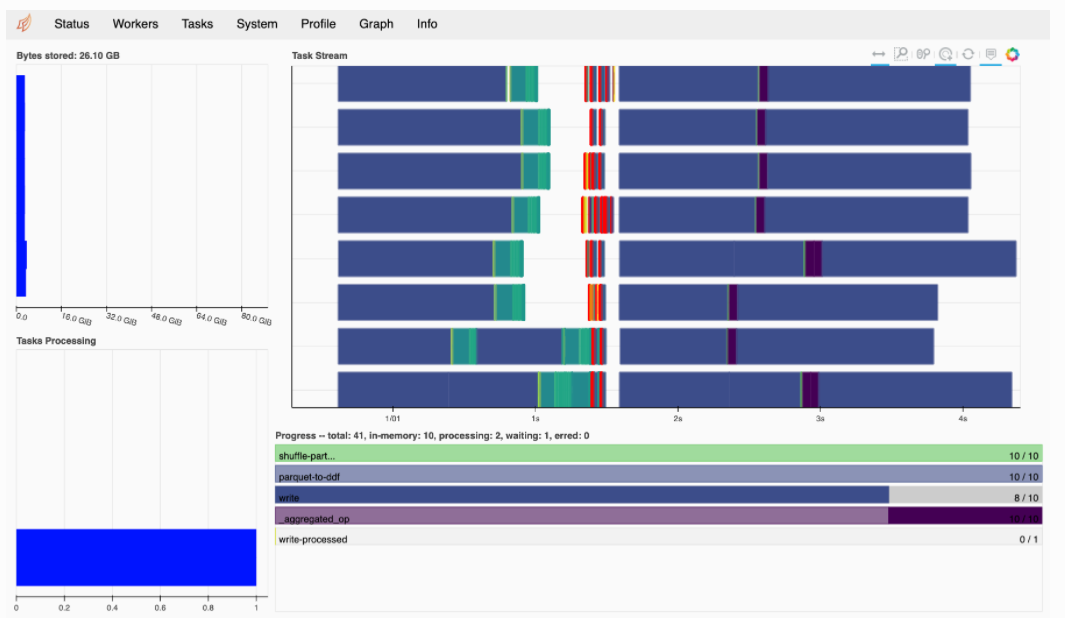



## Data Preprocessing

In [9]:
gdf = dask_cudf.read_csv(os.path.join(data_path, 'card_transaction.v1.csv'))

We start by cleaning up the column names and creating a `card_id` column by appending `card` number to `user` id.

In [10]:
# rename to lowercase and replace whitespace with underscore
gdf.columns = [i.lower().replace(" ", "_") for i in gdf.columns.tolist()]
gdf = gdf.rename(columns={'is_fraud?' : 'is_fraud', 'errors?' : 'errors'})
gdf['card_id'] = gdf['user'].astype('str') + gdf['card'].astype('str')

Note: Merchant name are hashed strings which is why we see long integers. 

Merchant name can be thought of as merchant_id for our purproses so we rename it to `merchant_id`

In [11]:
# rename merchant_name to merchant_id
gdf = gdf.rename(columns={'merchant_name': 'merchant_id'})
# convert card_id and merchant_id to int dtypes
gdf['card_id'] = gdf['card_id'].astype(int)
gdf['merchant_id'] = gdf['merchant_id'].astype(int)

## Train Test Split

Our transactions data spans Jan 1991 to Feb 2020. We set years 1990-2017 as training data,  2018-2020 as test data. This corresponds to roughly 85% train and 15% test split.

In [12]:
gdf['is_train'] = (gdf.year < 2018)

**NOTE:** We skip the code for ensuring that both train and test sets have same set of cards and merchants here because it's very similar to the single-GPU case.

### Renumbering node ids for DGL

In the graph we will build cards and merchants will be nodes with the `card_id` and `merchant_id` acting as the node ids. Since DGL requires the node ids to be renumbered in the range `0,1,2,,,N-1` where `N` is the total number of nodes we will have to renumber our `card_ids` to map them to to `0,1,2,..,N-1` through dask cuDF's `categorize()`. We will do the same thing for `merchant_id`.

In [13]:
gdf = gdf.categorize(columns=['card_id', 'merchant_id'])

We will fetch the unique `card_id` and `merchant_id` categories so that we can save them later.

In [14]:
uniq_card_id = gdf['card_id'].cat.categories
uniq_card_id = uniq_card_id.to_frame(name='card_id').reset_index(drop=True)

In [15]:
uniq_merch_id = gdf['merchant_id'].cat.categories
uniq_merch_id = uniq_merch_id.to_frame(name='merchant_id').reset_index(drop=True)

Now let's do the actual renumbering of `card_id` and `merchant_id`

In [16]:
gdf['card_id'] = gdf['card_id'].cat.codes
gdf['merchant_id'] = gdf['merchant_id'].cat.codes

Also create the training and test masks.

In [17]:
train_mask = gdf['is_train']

In [18]:
test_mask = ~gdf['is_train']

In [19]:
card_nodes = gdf['card_id'].astype('int64')
merch_nodes = gdf['merchant_id'].astype('int64')

## About DGL Heterograph

DGL's Heterograph supports creating the graph both on the CPU or GPU. Since very large scale graphs may not be able to fit in single GPU memory we may have to create the Heterograph in CPU memory. The Heterograph function also requires the data to be in Pytorch tensors so first we will need to convert `card_nodes`, `merchant_nodes`, to Pytorch tensors. If your processed dataframes can fit on GPU memory you can convert them to Pytorch Tensors on the GPU in a zero-copy fashion through [DLPack](https://github.com/dmlc/dlpack). Otherwise you can use Dask Pandas and Numpy to convert to Pytorch Tensors in CPU memory.

Now we are ready to create the graph structure using [`dgl.heterograph`](https://docs.dgl.ai/en/v0.7.0/generated/dgl.heterograph.html). It requires the `data_dict` which is the data dictionary for constructing a heterogeneous graph. The keys in the dictionary are in the form of string triplets `(src_type, edge_type, dst_type)`, specifying the source node, edge, and destination node types. The values are in the form `(U,V)`, where `U` and `V` are 1D tensors and `(U[i],V[i])` forms the edge with ID `i`.  So we will be able to create our heterograph by passing in this “tuple of node-tensors”

By default, every edge in DGL is directed so if we want both cardholder and merchants to have message passing between each other we need to add a reverse edge `transaction-rev` in addition to the `transaction` edge.

### Renumbering node ids for DGL

In the graph we will build cards and merchants will be nodes with the `card_id` and `merchant_id` acting as the node ids. Since DGL requires the node ids to be renumbered in the range `0,1,2,,,N-1` where `N` is the total number of nodes we will have to renumber our `card_ids` and `merchant_id` to map them to to `0,1,2,..,N-1` through Dask cuDF's `categorize()`.

In [20]:
gdf = gdf.categorize(columns=['card_id', 'merchant_id'])

/opt/conda/envs/rapids/lib/python3.8/site-packages/distributed/worker.py:3801: UserWarning: Large object of size 1.63 MiB detected in task graph: 
  ([['card_id', 0           0
1           1
2        ... type: int64]],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


We will fetch the unique `card_id` and `merchant_id` categories so that we can save them later.

In [21]:
uniq_card_id = gdf['card_id'].cat.categories
uniq_card_id = uniq_card_id.to_frame(name='card_id').reset_index(drop=True)

In [22]:
uniq_merch_id = gdf['merchant_id'].cat.categories
uniq_merch_id = uniq_merch_id.to_frame(name='merchant_id').reset_index(drop=True)

Now let's do the actual renumbering of `card_id` and `merchant_id`

In [23]:
gdf['card_id'] = gdf['card_id'].cat.codes
gdf['merchant_id'] = gdf['merchant_id'].cat.codes

## About DGL Heterograph

DGL's Heterograph supports creating the graph both on the CPU or GPU. Since very large scale graphs may not be able to fit in single GPU memory we may have to create the Heterograph in CPU memory. The Heterograph function also requires the data to be in Pytorch tensors so first we will need to convert the processed `card_nodes`, `merchant_nodes`, to Pytorch tensors. 

Here we assume that processed `card_nodes` and `merchant_nodes` columns are so big that they won't fit in single-GPU memory (if they fit we can use dlpack just like in previous notebook to convert them to Pytorch tensors) so then for conversion to Pytorch tensors we will convert the dask cudf dataframe to a Dask Pandas Dataframe, convert its columns to numpy arrays then finally to Pytorch tensors.

In [24]:
gdf = gdf.map_partitions(lambda df: df.to_pandas())

In [25]:
card_nodes_np =  gdf['card_id'].values.compute()
card_nodes_np = card_nodes_np.astype('int64')

In [26]:
merch_nodes_np =  gdf['merchant_id'].values.compute()
merch_nodes_np = merch_nodes_np.astype('int64')

Now we are ready to create the graph structure using [`dgl.heterograph`](https://docs.dgl.ai/en/v0.7.0/generated/dgl.heterograph.html). It requires the `data_dict` which is the data dictionary for constructing a heterogeneous graph. The keys in the dictionary are in the form of string triplets `(src_type, edge_type, dst_type)`, specifying the source node, edge, and destination node types. The values are in the form `(U,V)`, where `U` and `V` are 1D tensors and `(U[i],V[i])` forms the edge with ID `i`.  So we will be able to create our heterograph by passing in this “tuple of node-tensors”

By default, every edge in DGL is directed so if we want both cardholder and merchants to have message passing between each other we need to add a reverse edge `transaction-rev` in addition to the `transaction` edge.

In [27]:
# convert to torch int64 tensor
card_nodes_tensor = torch.from_numpy(card_nodes_np)

In [28]:
merch_nodes_tensor = torch.from_numpy(merch_nodes_np)

In [29]:
data_dict = {('card',  'transaction', 'merchant') : (card_nodes_tensor, merch_nodes_tensor),
            ('merchant', 'transaction-rev', 'card') : (merch_nodes_tensor, card_nodes_tensor)}

In [30]:
g = dgl.heterograph(data_dict)

In [31]:
g

Graph(num_nodes={'card': 6139, 'merchant': 100343},
      num_edges={('card', 'transaction', 'merchant'): 24386900, ('merchant', 'transaction-rev', 'card'): 24386900},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')])

## Save Graph and Data

We will use the `save_graphs` function in DGL to save the heteograph in binary format for later use. 

In [32]:
dgl.save_graphs(os.path.join(processed_path, "transaction_graph.bin"), [g])

Let's also save the `card_id` and `merchant_id` mapping as that will be useful later.

In [33]:
uniq_card_id.to_parquet(os.path.join(processed_path, 'uniq_card_id.parquet'))

In [34]:
uniq_merch_id.to_parquet(os.path.join(processed_path, 'uniq_merch_id.parquet'))

Finally we save the processed transactions dataset.

In [35]:
gdf.to_parquet(os.path.join(processed_path, 'subset_transactions.parquet'))

## Important - Cleanup

Run the code below to shutdown the running dask cluster and free GPU resources.

In [36]:
client.close()

In [37]:
client.shutdown()

**NOTE: Also please restart the kernel before moving on to the next notebook.**